<center><br>
## Открытый курс по машинному обучению. Сессия № 3
<img src="https://article.images.consumerreports.org/c_lfill,w_1920,ar_32:11/prod/content/dam/CRO%20Images%202017/Cars/March/CR-Cars-Hero-Used-Car-Sales-03-17">


### <center> Автор материала: Юлия Климушина

## <center> Прогноз цен на подержанные автомобили </center>
### <center> Индивидуальный проект по анализу данных

В этом проекте мы будем решать задачу восстановления регрессии. Данные, используемые в этом проекте, можно скачать [тут](https://www.kaggle.com/orgesleka/used-cars-database). Датасет содержит информацию о подержанных автомобилях, выставленных на продажу на Ebay в марте-апреле 2016. Данные представлены на немецком языке. 
Цель исследования: создание модели, предсказывающую цену автомобиля на вторичном рынке. Такая модель может помочь: 
- владельцу авто, желающему продать своего железого коня, не продешевить;
- покупателю не переплатить;
- диллеру, занимающемуся перепродажей машин, определить насколько выгодно конкретное предложение, за какую цену  можно перепродать автомобиль.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor 
from scipy.sparse import csr_matrix, hstack
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_SEED = 17
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

###  1. Описание набора данных и признаков

#### Список признаков:
- **dateCrawled**: дата и время первого просмотра объявления 
- **name** : название машины (сформировано из названия марки, модели и другой информации)
- **seller** : кто продает ('privat' - частное лицо, 'gewerblich' - диллер)
- **offerType** : тип предложения ('Angebot' - продажа, 'Gesuch' - покупка)
- **price** : цена
- **abtest** : A/B тест. Покопавшись в интернете, я выяснила, что A/B тестирование - это тактика, с помощью которой макетологи выясняют, какие заголовки объявления, текст, изображения, призывы к действию будут лучше работать для целевой аудитории.
- **vehicleType** : тип авто ('coupe', 'suv', 'kleinwagen', 'limousine', 'cabrio', 'bus', 'kombi', 'andere' - "купе", "внедорожник", "миниавто", "седан", "кабриолет", "автобус", "комби", "другое", соответственно)
- **yearOfRegistration** : в каком году машина была впервые зарегистрирована
- **gearbox** : тип коробки передач ('manuell' - ручная, 'automatik' - автоматическая)
- **powerPS** : мощность
- **model** : модель
- **kilometer** : пробег в километрах
- **monthOfRegistration** : в каком месяце машина была впервые зарегистрирована
- **fuelType** : тип топлива
- **brand** : марка
- **notRepairedDamage** : есть ли повреждения, требующие ремонта ('ja' - да, 'nein' - нет)
- **dateCreated** : дата и время создания объявления на eBay
- **nrOfPictures** : количество фотографий автомобиля (к сожалению, это поле везде содержит нули и поэтому бесполезно)
- **postalCode** : почтовый индекс
- **lastSeenOnline** : дата и время последнего просмотра объявления

Целевая переменная: **price** - цена автомобиля. Перед нами стоит задача восстановления регрессии.

###  2. Первичный анализ и обработка признаков

Посмотрим на данные

In [3]:
parse_dates = ['dateCrawled', 'dateCreated', 'lastSeen']
df = pd.read_csv('data/autos.csv', sep=',', parse_dates=parse_dates, encoding = 'ISO-8859-1')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06 10:17:21


In [4]:
df.shape

(371528, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
dateCrawled            371528 non-null datetime64[ns]
name                   371528 non-null object
seller                 371528 non-null object
offerType              371528 non-null object
price                  371528 non-null int64
abtest                 371528 non-null object
vehicleType            333659 non-null object
yearOfRegistration     371528 non-null int64
gearbox                351319 non-null object
powerPS                371528 non-null int64
model                  351044 non-null object
kilometer              371528 non-null int64
monthOfRegistration    371528 non-null int64
fuelType               338142 non-null object
brand                  371528 non-null object
notRepairedDamage      299468 non-null object
dateCreated            371528 non-null datetime64[ns]
nrOfPictures           371528 non-null int64
postalCode             371528 non-null int64
lastSe

Давайте избавимся от пропусков и не информативных признаков.
**abtest** явно лишний признак, так как не имеет отношения к автомобилям как таковым. Насколько мне удалось выяснить, это некий показатель, используемый Ebay для определения эффективности рекламы. 

Меня интересуют только объявления о продаже, поэтому я удалю строки о покупке и признак **offerType**.<br>
Признак **vehicleType** содержит пропуски. Можно заменить их значением, обозначающим "другое" (andere)<br>
Строки с пропусками в **gearbox** удалим.

In [6]:
df.drop([ 'abtest'], axis=1, inplace=True)
df = df[df['offerType'] != 'Gesuch'].drop('offerType', axis=1)

df['vehicleType'].fillna(axis=0, value='andere', inplace=True)

df.dropna(axis=0, subset=['gearbox'], inplace=True)

Давайте посмотрим на признак **brand**. 

In [7]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'porsche', 'toyota', 'chevrolet',
       'dacia', 'daihatsu', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'rover', 'land_rover', 'trabant', 'lada'], dtype=object)

"sonstige_autos" означает "прочие автомобили". Строк с такими значения немного и анализ показывает, что это старые и/или редкие машины, информации по которым не достаточно, чтобы строить прогноз, к тому же поле **model** у них не заполнено, поэтому удалим такие строки.

В признаке **model** 13433 пропусков, зато **brand** всегда заполнен. Учитывая, что **name** часто содержит в себе информацию о марке и модели, достанем модель оттуда. Строки, которые не подойдут под алгоритм, удалим. После этой операции удалим переменную **name**, он нам больше не пригодится.

In [8]:
df = df[df['brand'] != "sonstige_autos"]

In [9]:
model_nan_idx = df[pd.isnull(df["model"])].index
def model_extractor(x):
    x = x.apply(str.lower)
    name = x['name'].split(sep='_')
    try:
        if name[0] == x["brand"]:
            return name[1]
        else: return np.nan
    except:
        return np.nan

df.loc[model_nan_idx, 'model'] = df.loc[model_nan_idx][['name', 'brand']].apply(model_extractor, axis=1) 
df.dropna(axis=0, subset=['model'], inplace=True)
df.drop('name', axis=1, inplace=True)

Разберемся с топливом **fuelType**. Заменим пустующие значения 'andere' ('другое'). 

In [10]:
df['fuelType'].value_counts(dropna=False)

benzin     211809
diesel     102533
NaN         22228
lpg          5002
cng           546
hybrid        241
andere        114
elektro        66
Name: fuelType, dtype: int64

In [11]:
df['fuelType'].fillna(axis=0, value='andere', inplace=True)

Признак **notRepairedDamage** имеет 56335 пропусков. Можно исходить из предположения, что если владелец не упомянул в объявлении про повреждения, то он продает её как не требующую ремонта. Пометим такие пропуски как 'nein' и приведем к бинарному формату.

In [12]:
df['notRepairedDamage'].fillna(value='nein', inplace=True)
df['notRepairedDamage'] = df['notRepairedDamage'].map({'ja': 1, 'nein': 0}).astype('int64')

Посмотрим на статистику.

In [13]:
df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
dateCrawled,342539,264509,2016-03-24 14:49:47,6,2016-03-05 14:06:22,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller,342539,2,privat,342536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,342539,NaN,NaN,NaN,NaN,NaN,9193.5,522358,0,1200,3000,7500,1e+08
vehicleType,342539,8,limousine,91706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearOfRegistration,342539,NaN,NaN,NaN,NaN,NaN,2003.77,34.4349,1000,1999,2004,2008,9000
gearbox,342539,2,manuell,267849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
powerPS,342539,NaN,NaN,NaN,NaN,NaN,119.978,188.264,0,75,109,150,20000
model,342539,1027,golf,28612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,342539,NaN,NaN,NaN,NaN,NaN,126253,39023.5,5000,125000,150000,150000,150000
monthOfRegistration,342539,NaN,NaN,NaN,NaN,NaN,5.89832,3.63351,0,3,6,9,12


Основные выводы:
**nrOfPictures** по нулям. Удаляем этот признак.
в **price** наблюдаются большие выбросы (10 в восьмой многовато даже для Bloodhound SSC)
**kilometer** - имеет скошенное влево распределение

In [14]:
df.drop('nrOfPictures', axis=1, inplace=True)

###  3. Визуальный анализ признаков. Особенности данных.

Посмотрим на разброс значений количественных признаков: цены, года первой регистации и мощности.

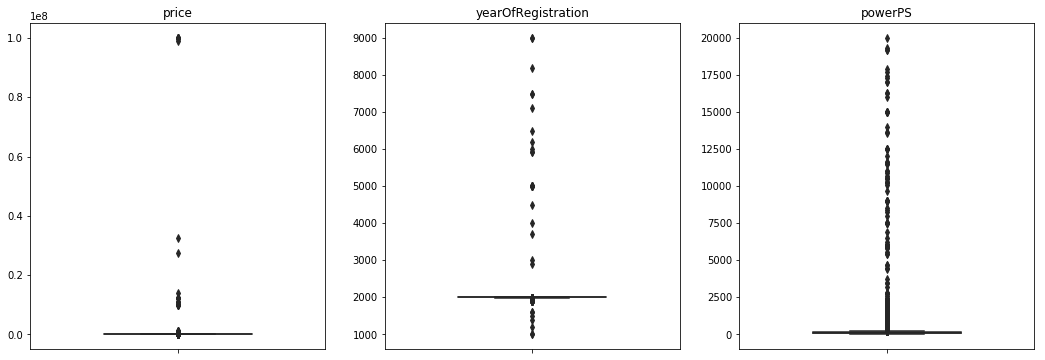

In [15]:
feats = ['price', 'yearOfRegistration', 'powerPS']
fig, axes = plt.subplots(ncols=len(feats), nrows=1, figsize=(18,6))

for i, feat in enumerate(feats):
    sns.boxplot(df[feat], ax=axes[i], orient='v', width=0.5, color='g');
    axes[i].set_ylabel('')
    axes[i].set_title(feat)


Из-за выбросов ничего не разобрать. Начнем с цен, определим пороги отсечения выбросов. Просмотр объявлений о продаже показали, что старая машина (15-20 лет) может стоить в районе 100 евро. В качестве верхней границы возьмем 150000. Именно столько стоят Porsche, которых не так уж мало в наборе.   

In [16]:
df = df[(df['price'] >= 100) & (df['price'] <= 150000)]

Посмотрим на год первой регистрации. Это важный признак, т.к. возраст автомобиля один из ключевых факторов, влияющих на его цену. Очевидно, что год регистрации не может быть позднее, чем год размешения объявлений. Объявления размещены в марте и апреле 2016, поэтому 2016-й год также не будем рассматривать. 17141 автомобилей зарегистрированы в 2016 и позднее. Удалим эти строки и машины старее 1976 года, то есть оставляем период в 40 лет.

In [17]:
df = df[(df['yearOfRegistration'] >= 1976) & (df['yearOfRegistration'] < 2016)]

В выборке есть достаточно автомобилей марки Porsche, мощность двигателей которых может превышать 500 л.с. Также есть авто марки Fiat с мощность движка не превышающим 30 лошадок. Возьмем ннтервал допустимых значений (20, 600). И построим ящики с усами.

In [18]:
df = df[(df['powerPS'] > 20) & (df['powerPS'] < 600)]

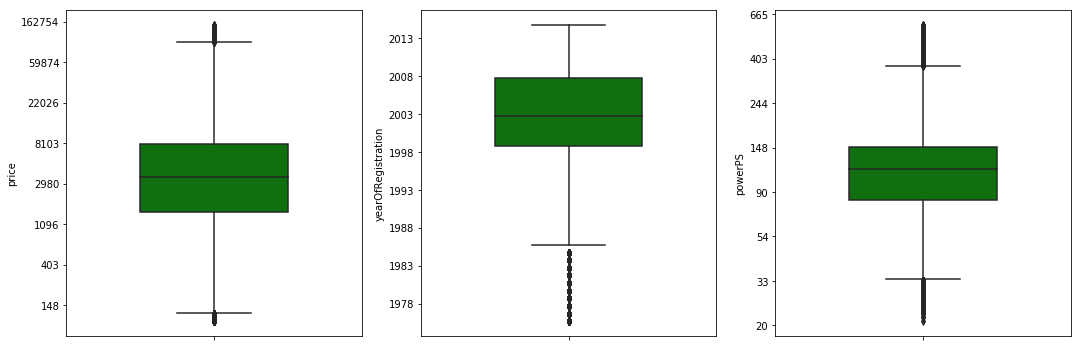

In [19]:
from matplotlib.ticker import FuncFormatter
feats = ['price', 'yearOfRegistration', 'powerPS']

fig, axis = plt.subplots(ncols=3, figsize=(18, 6))
for i, feat in enumerate(feats):
    sns.boxplot(np.log(df[feat]), ax=axis[i], orient='v', width=0.5, color='g');
    y_formatter = FuncFormatter(lambda x, pos: ('%i')%(np.exp(x)))
    axis[i].yaxis.set_major_formatter(y_formatter)

Признак **monthOfRegistration** целочисленный, но для модели не имеет смысла сравнивать январь с сентябрем, поэтому переквалифицируем его в категориальный. Месяц 0 будем рассматривать, как "не определено". Как видно из гистограммы с марта по июль публикуется больше объявлений о продаже авто, чем в остальные месяцы.

In [20]:
df['monthOfRegistration'] = df['monthOfRegistration'].astype('object')

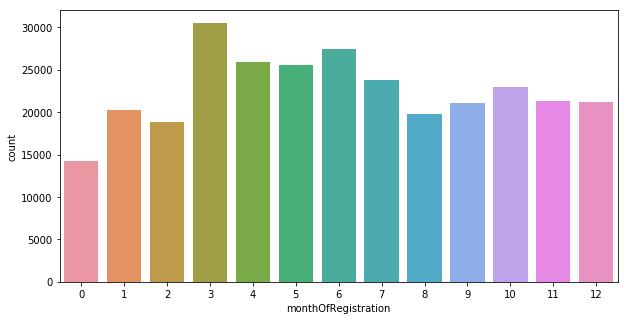

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(df['monthOfRegistration']); 

Посмотрим на распределение количественных и бинарных признаков.

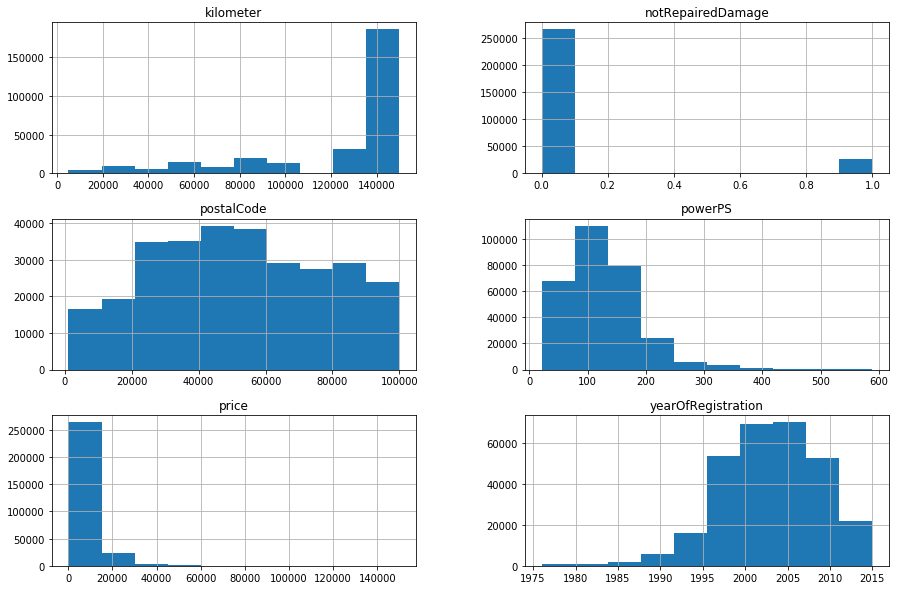

In [22]:
df.hist(figsize=(15, 10));

In [23]:
print('Доля машин с пробегом 150000 км: ', df[df['kilometer'] == 150000].shape[0] / df.shape[0])

Доля машин с пробегом 150000 км:  0.6358391369657245


Обратим внимание на пробег. Медиана и максимум = 150000. 65% машин имеют пробег 150000 км и мы имеем скошенное распределение (длинный левый хвост). У распределений целевой переменной **price** и мощности **powerPS** видим длинный правый хвост. Попробуем преобразовать данные, с тем, чтобы приблизить их распределения к нормальному. Для этого пробег возведем в степень, а **price** и **powerPS** - логарифмируем.

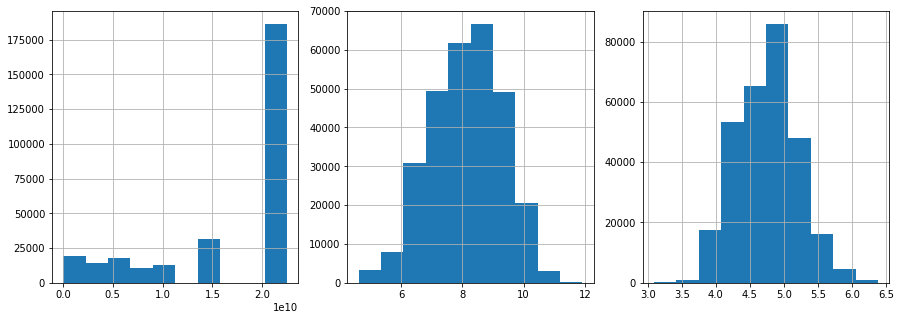

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
(df['kilometer'] ** 2).hist(ax=axes[0]);
np.log1p(df['price']).hist(ax=axes[1]);
np.log1p(df['powerPS']).hist(ax=axes[2]);

Изобразим матрицу корреляции

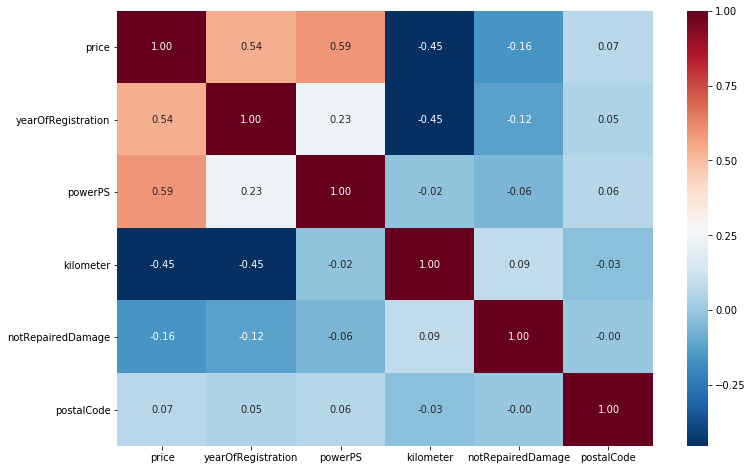

In [25]:
pal = sns.light_palette("green", as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="RdBu_r", annot=True, fmt = '.2f', ax=ax);

**Price** положительно коррелирует с **yearOfRegistration** и **powerPS** и отрицательно - с **kilometer**. 

Посмотрим на некоторые категориальные признаки по отдельности.

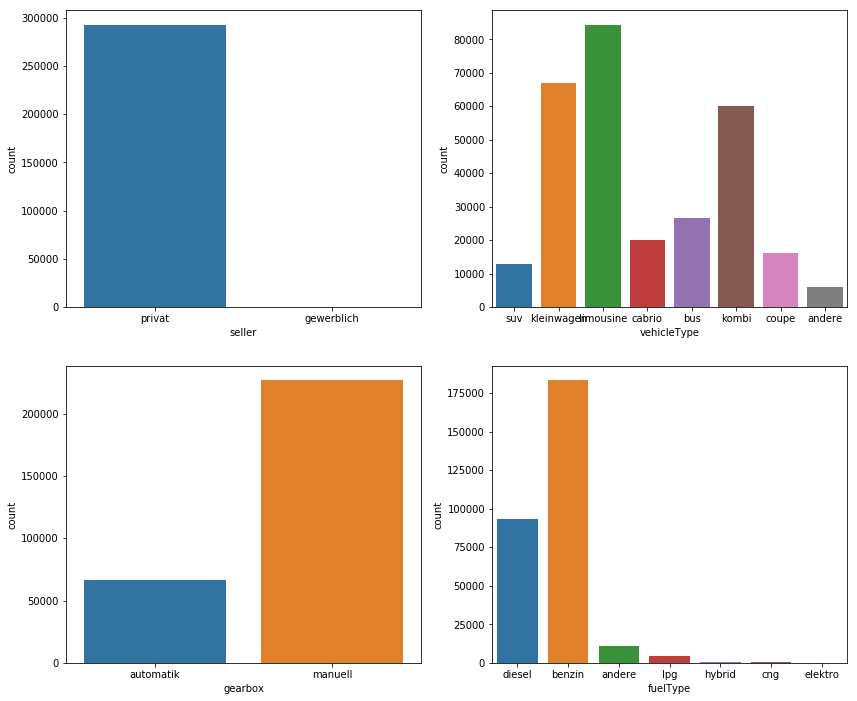

In [26]:
feats = ['seller', 'vehicleType', 'gearbox', 'fuelType']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
idx = 0
for i in range(2): 
    for j in range(2):
        sns.countplot(df[feats[idx]], ax=axes[i][j]); 
        idx += 1

Оказывается у нас только одна запись с **seller** == 'gewerblich', так что можно удалить этот признак. fuelType отличный от diesel и benzin объединим в общую группу andere.

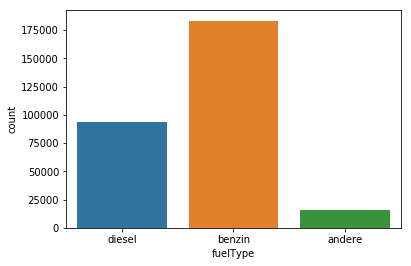

In [27]:
df.drop('seller', axis=1, inplace=True)
df['fuelType'].replace(['lpg', 'hybrid', 'cng', 'elektro'], 'andere', inplace=True)
sns.countplot(df['fuelType']);

Посмотрим на взаимодействие категориальных признаков и цены.

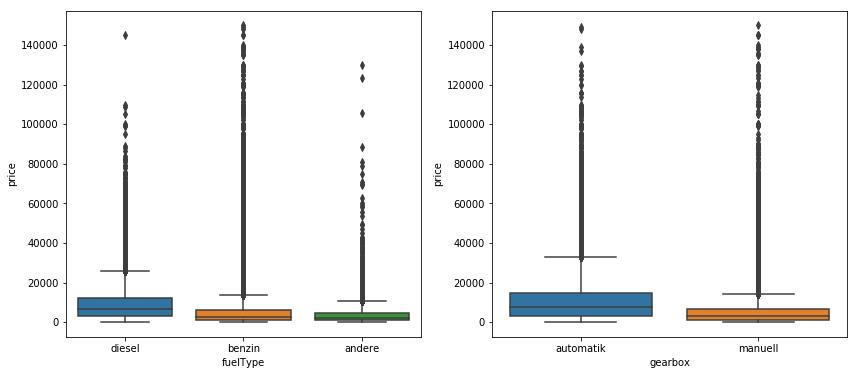

In [28]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.boxplot(x='fuelType', y='price', data=df, ax=axis[0]);
sns.boxplot(x='gearbox', y='price', data=df, ax=axis[1]);

Автомобили с дизельными двигателями дороже бензиновых и прочих, а машины с автоматической коробкой дороже, чем с ручной. 

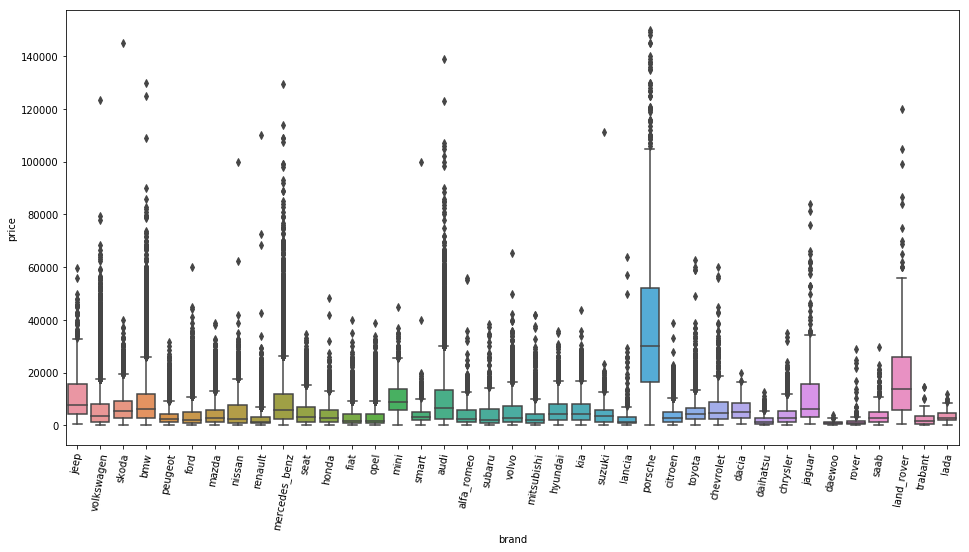

In [29]:
fig, axis = plt.subplots(figsize=(16, 8), )
sns.boxplot(x='brand', y='price', data=df);
axis.set_xticklabels(df['brand'].unique(), rotation=80);

Из этой картинки следует, что Porsche существенно дороже остальных марок.

Признак **postalCode** мы исключим. Если бы рассматривался российский или, к примеру, американский рынок, то имело бы смысл поработать с ним, так как цены от области к области (от штата к штату) варьируются. На Камчатке и Аляске они, вероятно, выше, чем по стране. Но поскольку речь идет о Германии, то отбросим этот признак.

In [30]:
df.drop(['postalCode'], axis=1, inplace=True)

###  Предобработка данных 

In [31]:
y = np.log1p(df['price'])
X = df.drop(['price'], axis=1)

Разделим данные на тренировочную и тестовую части и применим dummy-кодирование к категориальным признакам. 

In [33]:
X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.3, shuffle=True, stratify=X['brand'], random_state=RANDOM_SEED)
split_idx = X_train.shape[0]

In [34]:
for cat_feature in X.columns[X.dtypes == 'object']:
    X_train[cat_feature] = X_train[cat_feature].astype('category')  
    X_train[cat_feature].cat.set_categories(X_train[cat_feature].unique(), inplace=True)
    X_test[cat_feature] = X_test[cat_feature].astype('category')
    X_test[cat_feature].cat.set_categories(X_train[cat_feature].unique(), inplace=True)
    
# В тестовом наборе оказались модели, которых не было в тренировочном, появившиеся NaN замняем "andere" ("другое").
X_test['model'].fillna(value='andere', inplace=True)

In [35]:
X_train = pd.get_dummies(X_train, columns=X_train.columns[X_train.dtypes == 'category'])
X_test = pd.get_dummies(X_test, columns=X_test.columns[X_test.dtypes == 'category'])

In [36]:
X_train.shape, X_test.shape

((205044, 764), (87876, 764))

###  Построение базовых моделей. Выбор метрик качества. 

Давайте построим и сравним линейную модель и случайный лес. 

In [37]:
# Удаляем даты
X_train_base = X_train.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)
X_test_base = X_test.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)

#### Базовая модель линейной регрессии

Отмасштабируем признаки

In [38]:
scaler = StandardScaler().fit(X_train_base)
X_train_scaled = scaler.transform(X_train_base)
X_test_scaled = scaler.transform(X_test_base)

In [39]:
%%time
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

CPU times: user 1min 49s, sys: 29.9 s, total: 2min 18s
Wall time: 23 s


В качестве метрик качества линейной регрессии выберем MAE за его интерпретируемость. Также посмотрим на коэффициент детерминации, или коэффициент $R^2$. Данная мера качества — это нормированная среднеквадратичная ошибка. Чем она ближе к единице, тем лучше модель объясняет данные.

In [40]:
y_preds_lr = lr.predict(X_test_scaled)
print('LinearRegression:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds_lr))
print('\tR2: ', r2_score(y_test, y_preds_lr))

LinearRegression:
	MAE:  0.3700205712558758
	R2:  0.7929934947817355


#### Базовая модель случайного леса

In [41]:
%%time
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train_base, y_train)

CPU times: user 1min 16s, sys: 676 ms, total: 1min 17s
Wall time: 1min 17s


In [42]:
y_preds = rf.predict(X_test_base)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds))
print('\tR2: ', r2_score(y_test, y_preds))

RandomForestRegressor:
	MAE:  0.2810948947341652
	R2:  0.8688083341019125


In [43]:
print('Target range: (%.2f, %.2f) ' % (y.min(), y.max()))

Target range: (4.62, 11.92) 


Учитывая, что целевая переменная принимает значения в диапазоне (4.62, 11.51), то ошибка выглядит допустимой.

###  Создание новых признаков и описание этого процесса

Новые признаки, которые предположительно могут коррелировать с целевым: 
- **adUpDays** - сколько дней висело объявление   
- **kilPerYear** - среднегодовой пробег.

In [44]:
new_feats_train = pd.DataFrame(index=X_train.index)
new_feats_test = pd.DataFrame(index=X_test.index)

new_feats_train['adUpDays'] = (X_train['lastSeen'] - X_train['dateCrawled']).dt.days + 1
new_feats_test['adUpDays'] = (X_test['lastSeen'] -  X_test['dateCrawled']).dt.days + 1

new_feats_train['age'] = X_train['dateCrawled'].apply(lambda x: x.year) - X_train['yearOfRegistration']
new_feats_test['age'] = X_test['dateCrawled'].apply(lambda x: x.year) - X_test['yearOfRegistration']

new_feats_train['kilPerYear'] = X_train['kilometer'] / new_feats_train['age']
new_feats_test['kilPerYear'] = X_test['kilometer'] / new_feats_test['age']

X_train.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1, inplace=True)
X_test.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1, inplace=True)

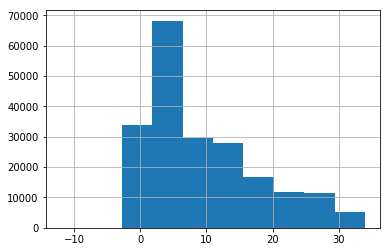

In [45]:
new_feats_train['adUpDays'].hist();

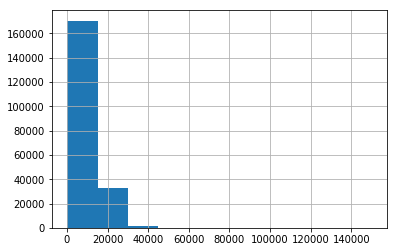

In [46]:
new_feats_train['kilPerYear'].hist();

Применим к признакам со смещенным распределением логарифмирование.

In [47]:
new_feats_train['kilPerYear_log'] = np.log1p(new_feats_train['kilPerYear'])
new_feats_test['kilPerYear_log'] = np.log1p(new_feats_test['kilPerYear'])

new_feats_train['powerPS_log'] = np.log1p(X_train['powerPS'])
new_feats_test['powerPS_log'] = np.log1p(X_test['powerPS'])

Добавление новых признаков и полиномов второй степени улучшило качество линейной модели, но оно всё же хуже, чем у базового случайного леса, поэтому сосредоточимся на последнем. 

In [48]:
scaler = StandardScaler().fit(X_train[['kilometer', 'yearOfRegistration']])
features_scaled_train = scaler.transform(X_train[['kilometer', 'yearOfRegistration']])
features_scaled_test = scaler.transform(X_test[['kilometer', 'yearOfRegistration']])

In [49]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(np.concatenate([new_feats_train[['powerPS_log', 'kilPerYear_log', 'adUpDays']],
                                                features_scaled_train], axis=1))
X_test_poly = poly.transform(np.concatenate([new_feats_test[['powerPS_log', 'kilPerYear_log', 'adUpDays']],
                                                features_scaled_test], axis=1))

In [50]:
X_train_new = np.concatenate([X_train_poly, X_train.drop(['powerPS', 'kilometer',  \
                                                           'yearOfRegistration'], axis=1)], axis=1)
X_test_new = np.concatenate([X_test_poly, X_test.drop(['powerPS', 'kilometer',  \
                                                       'yearOfRegistration'], axis=1)], axis=1)

In [51]:
%%time
lr = LinearRegression()
lr.fit(X_train_new, y_train)

CPU times: user 1min 53s, sys: 25.7 s, total: 2min 18s
Wall time: 25.8 s


In [52]:
y_preds_lr = lr.predict(X_test_new) 
print('LinearRegression:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds_lr))
print('\tR2: ', r2_score(y_test, y_preds_lr))

LinearRegression:
	MAE:  0.3164375496390628
	R2:  0.8529288462807411


Модель случайного леса немного улучшилась при добавлении **adUpDays**. Добавление **kilPerYear** никак не повлияло на качество.

In [56]:
X_train_new = pd.concat([X_train, new_feats_train[['kilPerYear']]], axis=1)
X_test_new = pd.concat([X_test, new_feats_test[['kilPerYear']]], axis=1)

In [57]:
%%time
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train_new, y_train)

CPU times: user 1min 19s, sys: 648 ms, total: 1min 20s
Wall time: 1min 20s


In [58]:
y_preds = rf.predict(X_test_new)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds))
print('\tR2: ', r2_score(y_test, y_preds))

RandomForestRegressor:
	MAE:  0.2807144067771242
	R2:  0.8692330143706801


In [64]:
X_train_new = pd.concat([X_train, new_feats_train[['adUpDays']]], axis=1)
X_test_new = pd.concat([X_test, new_feats_test[['adUpDays']]], axis=1)

In [60]:
%%time
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train_new, y_train)

CPU times: user 1min 19s, sys: 191 ms, total: 1min 19s
Wall time: 1min 19s


In [61]:
y_preds = rf.predict(X_test_new)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds))
print('\tR2: ', r2_score(y_test, y_preds))

RandomForestRegressor:
	MAE:  0.2784478399766084
	R2:  0.8723696499008463


Какие же признаки оказались наиболее важными для модели случайного леса. Как видно из графика ниже, наиболее важным признаком оказался год регистрации, второй по важности признак - мощность двигателя, третий - **notRepairedDamage**.

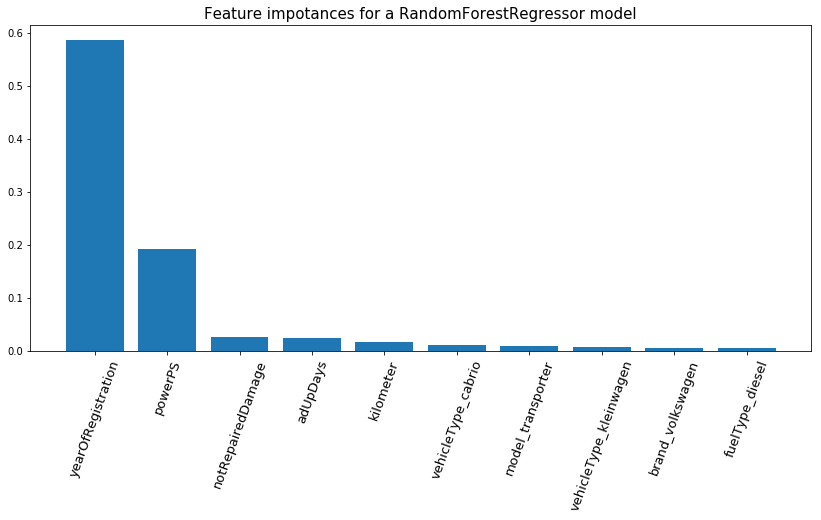

In [65]:
features = X_train_new.columns
importances = rf.feature_importances_
num_to_plot = 10
indices = np.argsort(importances)[::-1][:num_to_plot]
 
plt.figure(figsize=(14,6))
plt.title('Feature impotances for a RandomForestRegressor model', size=15)
bars = plt.bar(range(num_to_plot), importances[indices], align="center")
ticks = plt.xticks(range(num_to_plot), features.values[indices[:]], rotation=70, size=13)

###  Построение кривых валидации

Попробуем улучшить результат случайного леса. Для начала посмотрим как ведут себя кривые валидации при изменении основных параметров.

Начнем с количества деревьев:

In [67]:
def valid_curves_plot(hyperparam, param_range):
    param_range = param_range
    train_scores, test_scores = validation_curve(RandomForestRegressor(random_state=RANDOM_SEED), 
                                X_train_new, y_train, param_name=hyperparam, param_range=param_range, 
                                cv=kf, n_jobs=-1, scoring='r2')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(9,6))
    plt.title('Validation curves for a RandomForestRegressor model')
    plt.xlabel(hyperparam)
    plt.ylabel('R2')
    plt.ylim(0.8, 1.0)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, \
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, train_scores_mean, label='Training error', color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, \
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(param_range, test_scores_mean, label='Validation error', color="g")

    plt.legend(loc="best")
    plt.xticks(param_range)
    plt.show()

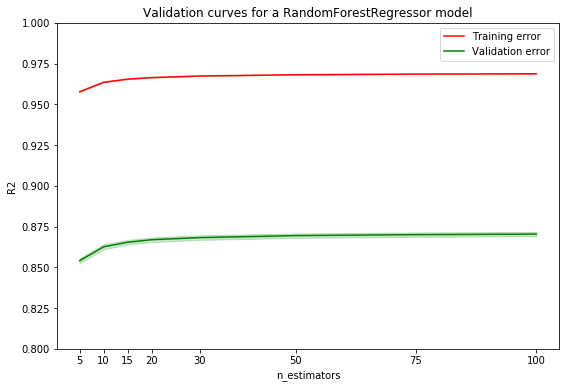

CPU times: user 19.5 s, sys: 2.33 s, total: 21.8 s
Wall time: 42min 50s


In [70]:
%%time
valid_curves_plot(hyperparam='n_estimators', param_range=[5, 10, 15, 20, 30, 50, 75, 100])

Как видно при достижении 30 деревьев точность модели на тесте выходит на асимптоту. 

Давайте посмотрим какие параметры регуляризации добавить в модель, чтобы недопустить переобучение.
Посмотрим как ведет себя модель в зависимости от параметра максимальной глубины – `max_depth`.

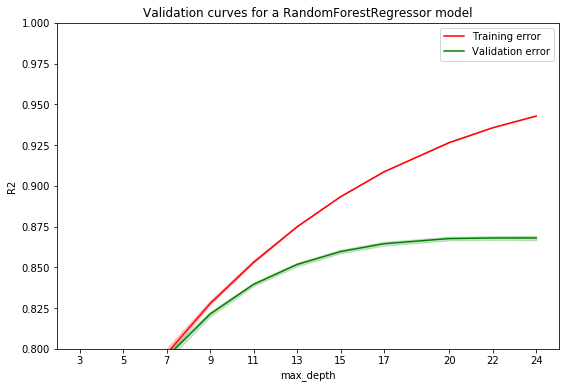

CPU times: user 23.6 s, sys: 1.98 s, total: 25.6 s
Wall time: 10min 4s


In [71]:
%%time
valid_curves_plot(hyperparam='max_depth', param_range=[3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24])

Как видим, строить деревья глубиной более 22 смысла не имеет, качество на тесте выходит на ассиптоту.<br> 
<br>
Построим кривые валидации для параметра `min_samples_leaf`.

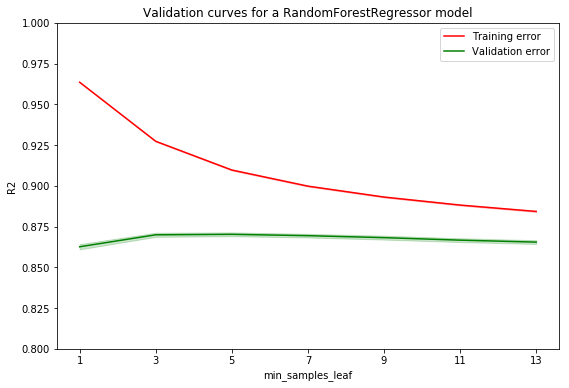

CPU times: user 15.3 s, sys: 1.53 s, total: 16.9 s
Wall time: 8min 4s


In [72]:
%%time
valid_curves_plot(hyperparam='min_samples_leaf', param_range=[1, 3, 5, 7, 9, 11, 13])

Как мы видим на тесте максимальное качество достигается, если минимальном числе объектов в листе 3. <br>
<br>
Параметр `max_features` определяет количество случайных признаков из `n`  исходных. Для задач регрессии рекомендуется использовать $\frac{n}{3}$. Давайте определим оптимальный параметр для нашего случая.

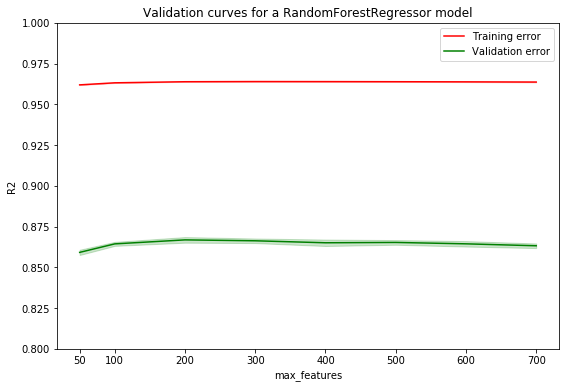

CPU times: user 17.8 s, sys: 1.5 s, total: 19.3 s
Wall time: 7min 5s


In [73]:
%%time
valid_curves_plot(hyperparam='max_features', param_range=[50, 100, 200, 300, 400, 500, 600, 700])

**max_features** = 200 - оптимальный вариант.

###  Кросс-валидация, подбор параметров

In [74]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [100,200, 300, 400, 500], 
              'min_samples_leaf': [1, 3, 5, 7], 
              'max_depth': [13, 15, 17, 20, 22, 24]}
rfc = RandomForestRegressor(n_estimators=30, random_state=RANDOM_SEED, n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=kf)
gcv.fit(X_train_new, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 3, 5, 7], 'max_features': [100, 200, 300, 400, 500], 'max_depth': [13, 15, 17, 20, 22, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
gcv.best_estimator_, gcv.best_score_

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
            max_features=200, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
 0.8801176354012498)

### Прогноз для тестовой выборки

Обучим случайный лес с оптимальными гиперпараметрами и получим прогноз для тестовой выборки. 

In [76]:
%%time
gcv.best_estimator_.fit(X_train_new, y_train)

CPU times: user 2min 57s, sys: 873 ms, total: 2min 58s
Wall time: 25.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features=200, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=17, verbose=0, warm_start=False)

In [77]:
y_preds = gcv.best_estimator_.predict(X_test_new)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds))
print('\tR2: ', r2_score(y_test, y_preds))

RandomForestRegressor:
	MAE:  0.2689071527534981
	R2:  0.8836972391517763


Нам удалось выиграть "аж" 0.01 на обоих метриках.

###  Оценка модели

Переведем целевой признак обратно в километры и посмотрим насколько хорошо наша модель отработала на тестовом наборе. Для начала сравним реальные и предсказанные цены по нескольким примерам.

In [78]:
y_test_preds = pd.DataFrame({'y_true': np.exp(y_test) - 1,
                           'y_preds': np.exp(y_preds) - 1})
y_test_preds['y_true'] =round(y_test_preds['y_true'], 2)
y_test_preds['y_preds'] =round(y_test_preds['y_preds'], 2)
y_test_preds['diff'] = np.absolute(y_test_preds['y_true'] - y_test_preds['y_preds'])
y_test_preds.head(20).T

,331865,281816,105039,365553,18253,289220,367269,326988,212097,279259,38123,286722,359805,363031,263592,35037,89607,287819,103711,328275
y_preds,1552.11,10049.54,7987.47,12343.62,5357.12,1138.47,18530.25,2285.7,856.01,1962.55,3639.48,1892.26,5794.73,9094.17,7662.2,647.19,9106.47,1517.07,1391.9,6515.98
y_true,1150.00,11990.00,9900.00,10500.00,4500.00,1299.00,19500.00,2500.0,1500.00,1700.00,2990.00,1250.00,4999.00,8950.00,6700.0,349.00,8900.00,800.00,700.0,5700.00
diff,402.11,1940.46,1912.53,1843.62,857.12,160.53,969.75,214.3,643.99,262.55,649.48,642.26,795.73,144.17,962.2,298.19,206.47,717.07,691.9,815.98


Как видим модель довольно сильно ошибается в некоторых случаях, но в целом закономерности в данных выявлены и результат выглядит неплохо. На графике ниже видим рассеяние реальной цены vs. предсказанной цены относительно линии идентичности (красная линия). Хорошо видно, что чем больше цена, тем сильнее ошибается модель и видно тенденцию к недооценке. Очевидно это связано с недостаточностью данных по дорогим автомобилям.  

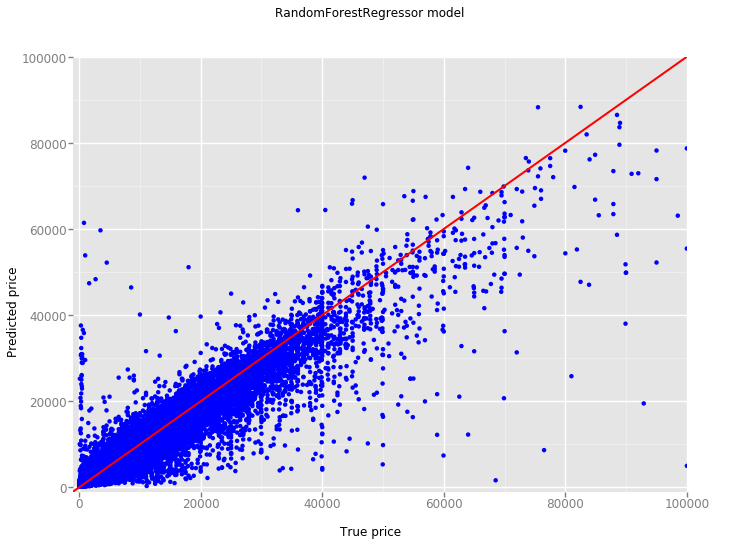

<ggplot: (8732041641820)>

In [79]:
from ggplot import *

ggplot(y_test_preds, aes(x='y_true',y='y_preds')) + \
    geom_point(color='blue')  + \
    xlim(-1e03,  1e+05) + ylim(-1e03, 1e+05) + \
    ggtitle("RandomForestRegressor model") + \
    xlab("True price") + ylab("Predicted price") + \
    geom_abline(intercept=0, size=2, color='red')

Также видим в самом начале какие-то сильные выбросы. Посмотрев на данные, становится ясно, что модель предсказывает более высокую стоимость машин, выставленных за "бесценок". Возможно продавцы указывают низкую цену, чтобы привлечь покупателей, а может забыли указать, что машина требует ремонта. 

In [80]:
y_test_preds.sort_values('y_true').head()

,y_preds,y_true,diff
257519,378.43,100.0,278.43
207452,127.30,100.0,27.30
162023,516.15,100.0,416.15
234667,512.03,100.0,412.03
36232,465.84,100.0,365.84


###  Построение кривых обучения

Давайте построим кривые обучения для всего объема данных.

CPU times: user 1h 26min 35s, sys: 1min 3s, total: 1h 27min 38s
Wall time: 16min 18s


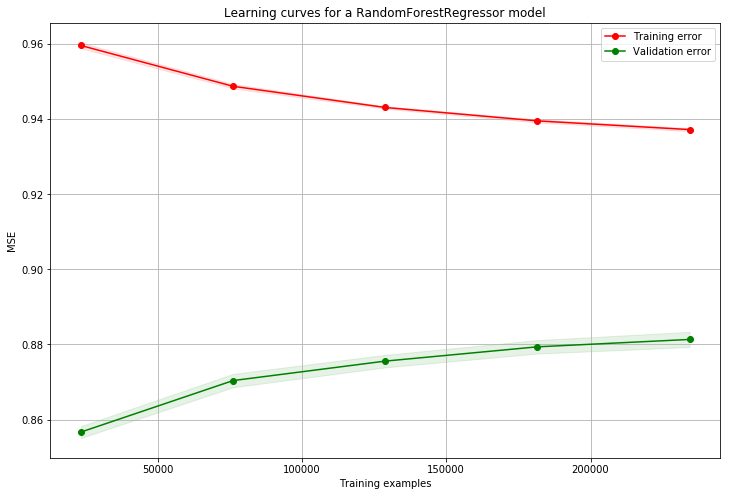

In [81]:
%%time

plt.figure(figsize=(12, 8))
plt.title("Learning curves for a RandomForestRegressor model")
plt.xlabel("Training examples")
plt.ylabel("MSE")
train_sizes, train_scores, test_scores = \
            learning_curve(RandomForestRegressor(max_depth=24,
                                                max_features=200,
                                                min_samples_leaf=1,
                                                n_estimators=30, n_jobs=-1,
                                                random_state=RANDOM_SEED), 
                            np.concatenate([X_train, X_test]),
                            np.concatenate([y_train, y_test]),
                            cv=kf,
                            train_sizes=np.linspace(0.1, 1.0, 5),
                            random_state=RANDOM_SEED)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validation error")
plt.legend()

Большое расстояние между кривыми указывает на переобучение. 

### Выводы 

Сырые данные содержали много пропусков и выбросы. Нам потребовалось провести значительную обработку и фильтрацию. К категориальным признакам мы применили one-hot encoding. Целевой признак имел сильно скошенное распределение, поэтому мы применили к нему логарифмическое преобразование.  

Мы сравнили две модели и пришли к выводу, что линейная модель с полиномиальными признаками дает MAE: 0.31 и $R^2$: 0.85, в то время как случайный лес "из коробки" сразу выдал MAE:  0.28 и $R^2$: 0.87. К сожалению, нам не удалось синтезировать признаки, улучшающие этот результат случайного леса. Настройка гиперпараметров привела к незначительному росту качества: MAE:  0.27 и $R^2$: 0.88. 

Учитывая, что случайный лес показал неплохие результаты, с моей стороны было бы упущением не попровать бустинг на наших данных. Я воспользовалась питоновской реализацией XGBoost, понастраивала параметры с помощью hyperopt, но значимых улучшений не получила, поэтому решила не докучать читателям и опустила выкладки. 

Таким образом можно заключить, что применительно к этой задаче случайный лес сработал хорошо.

Исходя из кривых обучения можно сделать вывод, чтобы улучшить модель можно:
- увеличить размер выборки;
- понизить сложность модели. Этого можно добиться, если использовать меньший набор признаков или увеличить регуляризацию (к примеру, можно снизить глубину деревьев или увеличить минимальном число объектов в листе).